**Problem Statement:** Develop a fraud analytics model that help to detect fraud from good and normal user activity and create measures for reaction.

**Data Set:** Anonymized synthetic data set

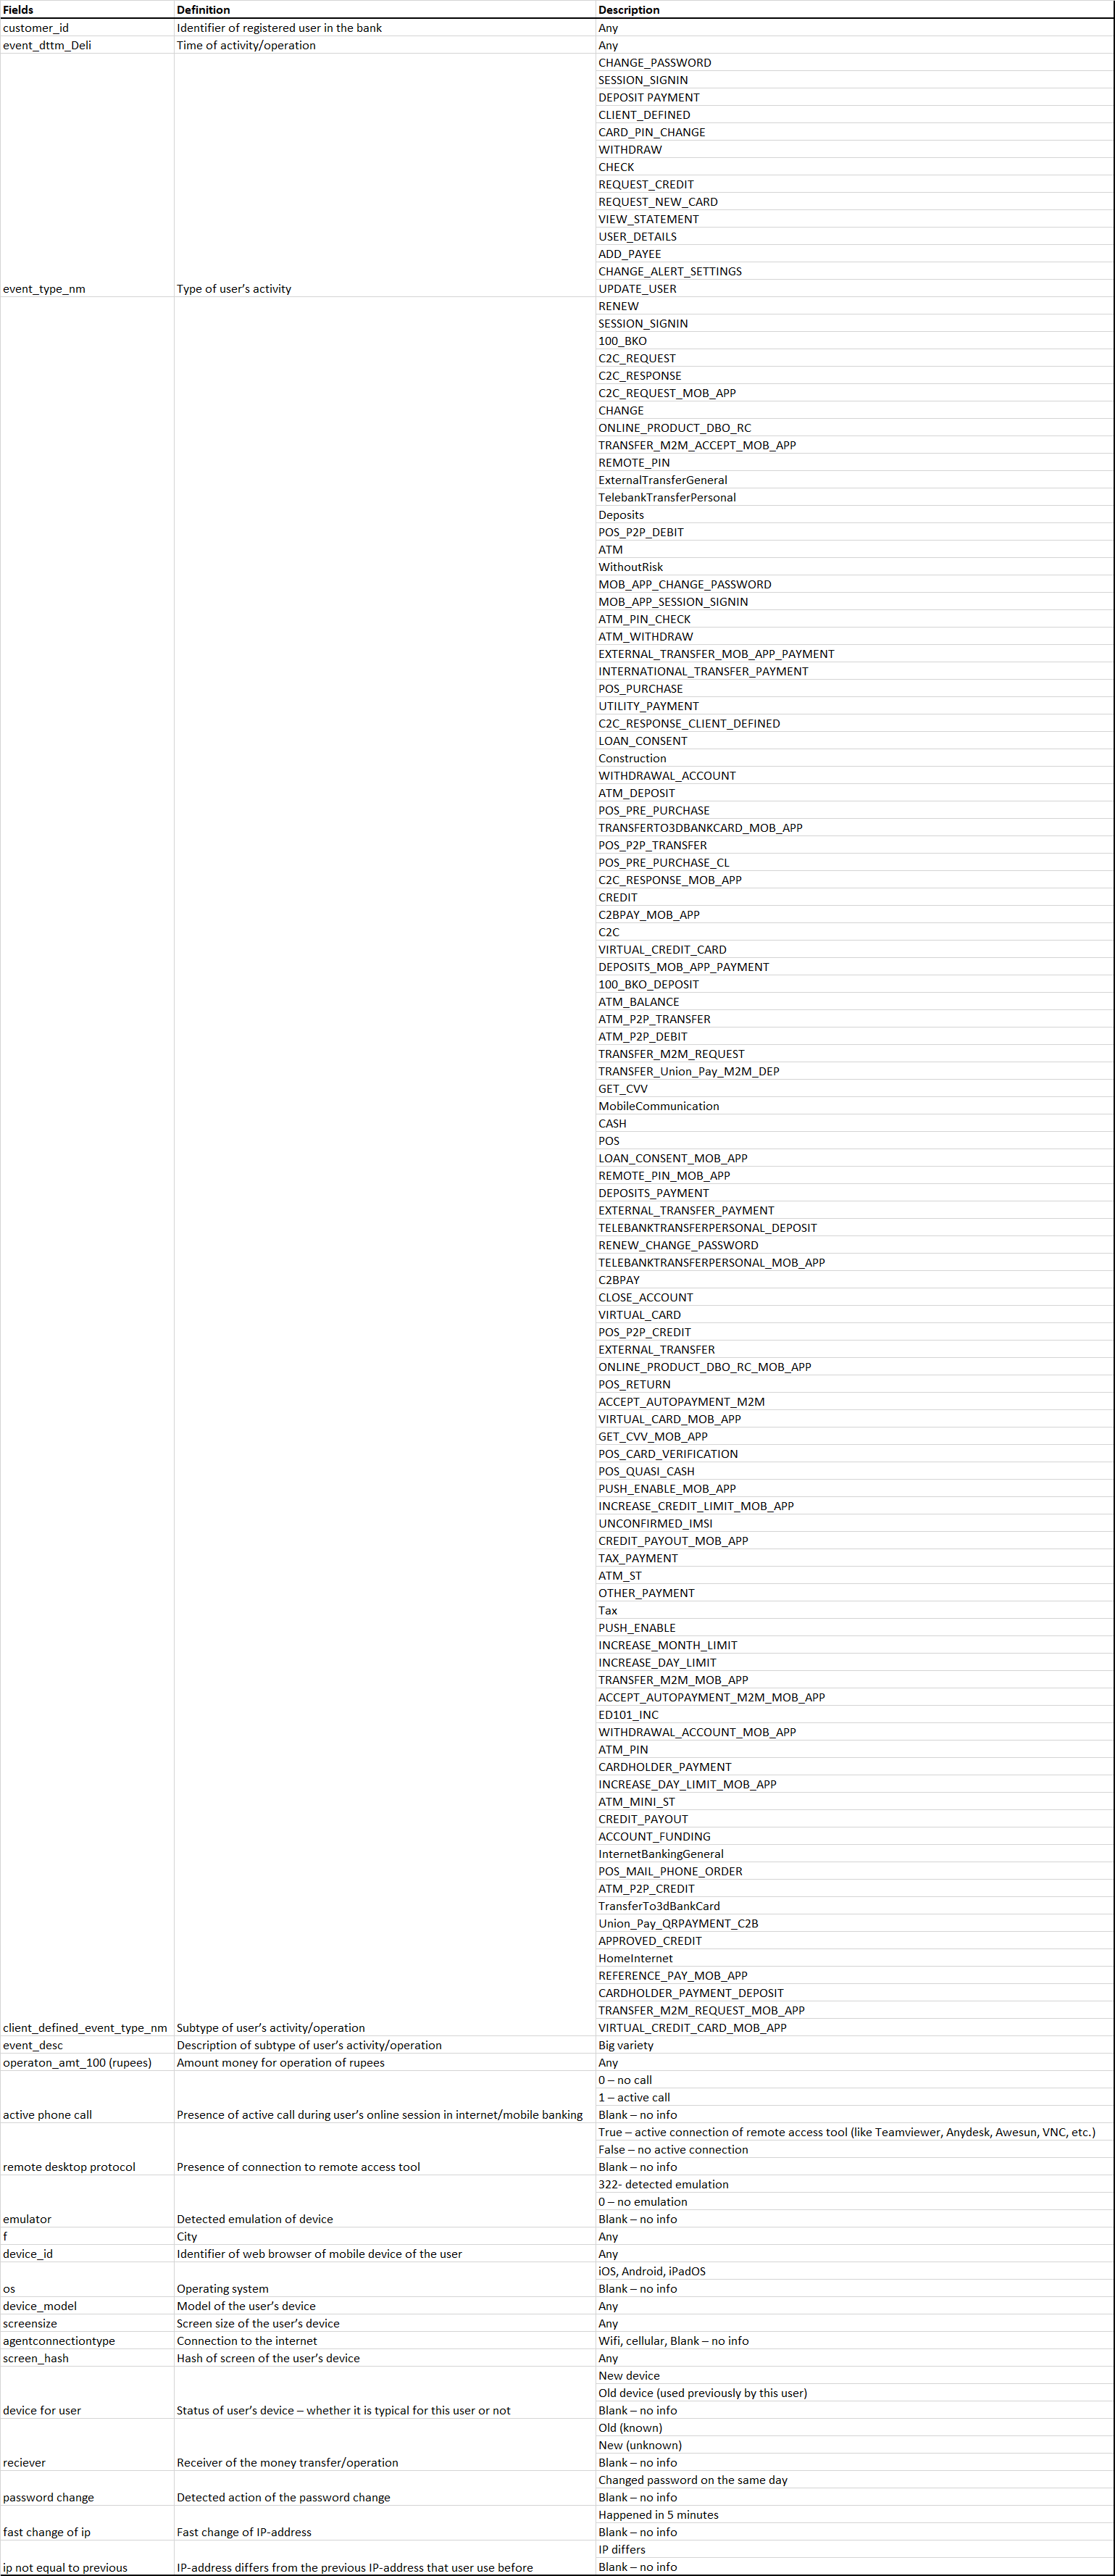

# Import libraries

In [120]:
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt

# Read dataset

In [121]:
df = pd.read_excel('Dataset_Datathon_Fraud_Detection_28122022.xlsx')

In [122]:
pd.set_option('display.max_columns', None)

In [123]:
df

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100 (rupees),active phone call,remote desktop protokol,emulator,f,device_id,os,device_model,screensize,agentconnectiontype,screen_hash,device for user,reciever,password change,fast change of ip,ip not equal to previous
0,customer_id_0,2022-10-01 10:51:36,CHANGE_PASSWORD,RENEW,Login password recovery,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,NaN,NaN,IP differes
1,customer_id_0,2022-10-01 11:15:21,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
2,customer_id_0,2022-10-01 11:31:55,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,-205759950.0,new,old,happened on the same day,NaN,IP differes
3,customer_id_0,2022-10-01 11:45:42,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.0,NaN,NaN,NaN,St Petersburg,NaN,NaN,NaN,NaN,NaN,287067538.0,new,old,happened on the same day,NaN,IP differes
4,customer_id_0,2022-10-03 10:28:24,DEPOSIT,100_BKO,Payment order,116820.0,1.0,0.0,NaN,NaN,device_id_1,iOS,iPhone,375x812,wifi,NaN,NaN,old,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10964,customer_id_199,2022-10-29 01:22:11,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,Login,0.0,0.0,0.0,NaN,Kalkutta,device_id_211,iOS,iPhone,375x812,cellular,NaN,old,old,NaN,NaN,IP differes
10965,customer_id_199,2022-10-29 12:12:53,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,Login,0.0,0.0,0.0,NaN,Vladikavkaz,device_id_211,iOS,iPhone,375x812,wifi,NaN,old,old,NaN,NaN,IP differes
10966,customer_id_199,2022-10-29 12:13:27,PAYMENT,UTILITY_PAYMENT,Cellular payment,944.0,0.0,0.0,NaN,Vladikavkaz,device_id_211,iOS,iPhone,375x812,wifi,NaN,old,old,NaN,NaN,IP differes
10967,customer_id_199,2022-10-29 15:26:58,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,Login,0.0,0.0,0.0,NaN,Kalkutta,device_id_211,iOS,iPhone,375x812,cellular,NaN,old,old,NaN,NaN,IP differes


In [124]:
pd.reset_option('display.max_columns')

# Rename columns

In [125]:
df.columns = [(('_'.join(c.split())).replace('(', '')).replace(')', '') for c in df.columns]

In [126]:
df.columns

Index(['customer_id', 'event_dttm_Deli', 'event_type_nm',
       'client_defined_event_type_nm', 'event_desc', 'operaton_amt_100_rupees',
       'active_phone_call', 'remote_desktop_protokol', 'emulator', 'f',
       'device_id', 'os', 'device_model', 'screensize', 'agentconnectiontype',
       'screen_hash', 'device_for_user', 'reciever', 'password_change',
       'fast_change_of_ip', 'ip_not_equal_to_previous'],
      dtype='object')

# Check data

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10969 entries, 0 to 10968
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   10969 non-null  object        
 1   event_dttm_Deli               10969 non-null  datetime64[ns]
 2   event_type_nm                 10969 non-null  object        
 3   client_defined_event_type_nm  9554 non-null   object        
 4   event_desc                    10800 non-null  object        
 5   operaton_amt_100_rupees       10969 non-null  float64       
 6   active_phone_call             3778 non-null   float64       
 7   remote_desktop_protokol       3786 non-null   float64       
 8   emulator                      2923 non-null   float64       
 9   f                             4666 non-null   object        
 10  device_id                     3786 non-null   object        
 11  os                          

# Distribution of categorical and numeric columns

In [128]:
df.nunique()

customer_id                       200
event_dttm_Deli                 10837
event_type_nm                      15
client_defined_event_type_nm      100
event_desc                         76
operaton_amt_100_rupees          1815
active_phone_call                   2
remote_desktop_protokol             2
emulator                            2
f                                  82
device_id                         211
os                                  3
device_model                      114
screensize                         92
agentconnectiontype                 2
screen_hash                       115
device_for_user                     2
reciever                            2
password_change                     1
fast_change_of_ip                   1
ip_not_equal_to_previous            1
dtype: int64

In [129]:
df.describe()

,operaton_amt_100_rupees,active_phone_call,remote_desktop_protokol,emulator,screen_hash
count,1.096900e+04,3778.000000,3786.000000,2923.000000,1.167000e+03
mean,3.579496e+04,0.059820,0.004754,0.220322,5.379749e+08
std,2.025458e+05,0.237184,0.068797,8.421358,8.987965e+08
min,0.000000e+00,0.000000,0.000000,0.000000,-9.983340e+08
25%,0.000000e+00,0.000000,0.000000,0.000000,-1.407479e+08
50%,2.407200e+02,0.000000,0.000000,0.000000,2.879911e+08
75%,2.832000e+03,0.000000,0.000000,0.000000,1.346333e+09
max,6.178480e+06,1.000000,1.000000,322.000000,2.010243e+09


In [130]:
pd.set_option('display.max_rows', None)
df['screen_hash'].value_counts()

 2.870675e+08    107
 1.577027e+09     79
-9.926046e+08     38
 1.925220e+09     38
 2.879911e+08     37
-1.288858e+08     32
-2.143538e+08     32
-9.130534e+08     30
 4.167013e+08     29
 1.577950e+09     29
 1.795216e+09     29
 1.346333e+09     28
 1.022209e+09     28
 1.741264e+09     27
-3.507399e+08     26
-2.057600e+08     24
 1.313228e+09     21
 1.740340e+09     20
 5.901883e+07     18
 1.026398e+09     17
-1.318269e+08     17
-9.121299e+08     17
-6.628388e+08     17
 1.267276e+09     17
 9.377575e+08     16
-5.347200e+05     15
 1.149057e+09     15
-1.405986e+08     14
-1.407479e+08     13
 4.922545e+08     13
 1.970526e+09     13
-9.983340e+08     13
 5.994235e+07     13
 1.037247e+09     12
-7.676401e+08     11
 1.796140e+09     11
-3.498163e+08     10
 9.386810e+08     10
-1.317345e+08      9
 1.347257e+09      9
-6.043268e+08      9
 6.777584e+08      7
 1.314151e+09      7
-1.933115e+08      7
-3.303005e+08      7
 2.010243e+09      7
 1.086835e+09      6
-2.050124e+07

In [131]:
pd.reset_option('display.max_rows')

# Missing values
##### Numeric
- active_phone_call: missing = 0
- remote_desktop_protokol: missing = 0
- emulator: missing = 1
- screen_hash: missing = 0

##### Non-numeric
- *blank*

In [132]:
values = {'active_phone_call': 0, 'remote_desktop_protokol': 0, 'emulator': 1, 'screen_hash': 0}
df.fillna(value=values, inplace=True)
df.fillna('', inplace=True)

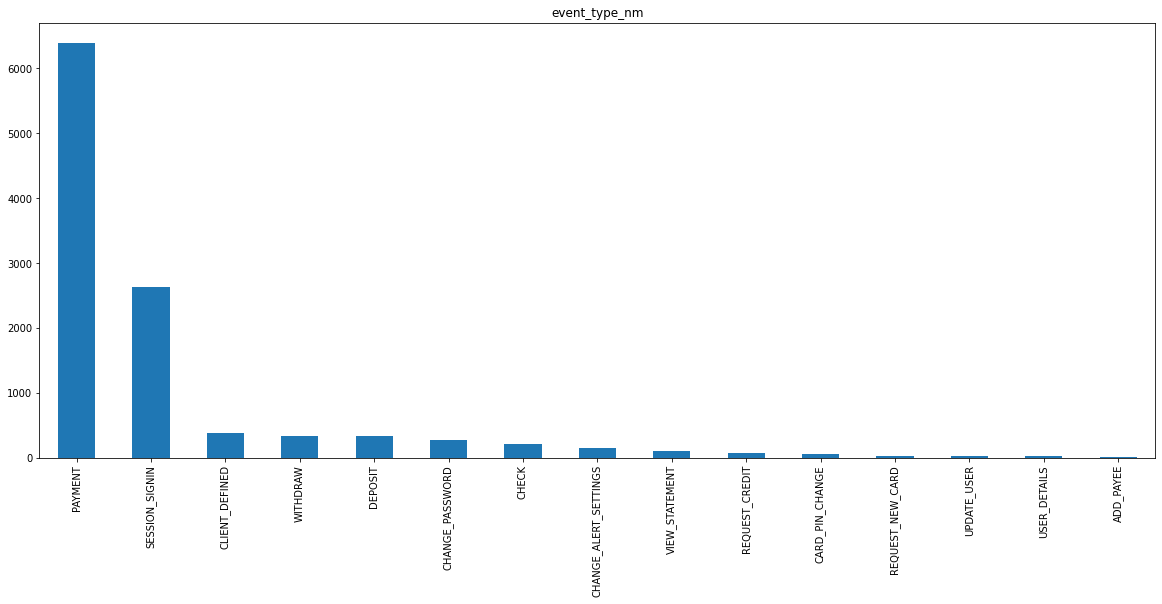

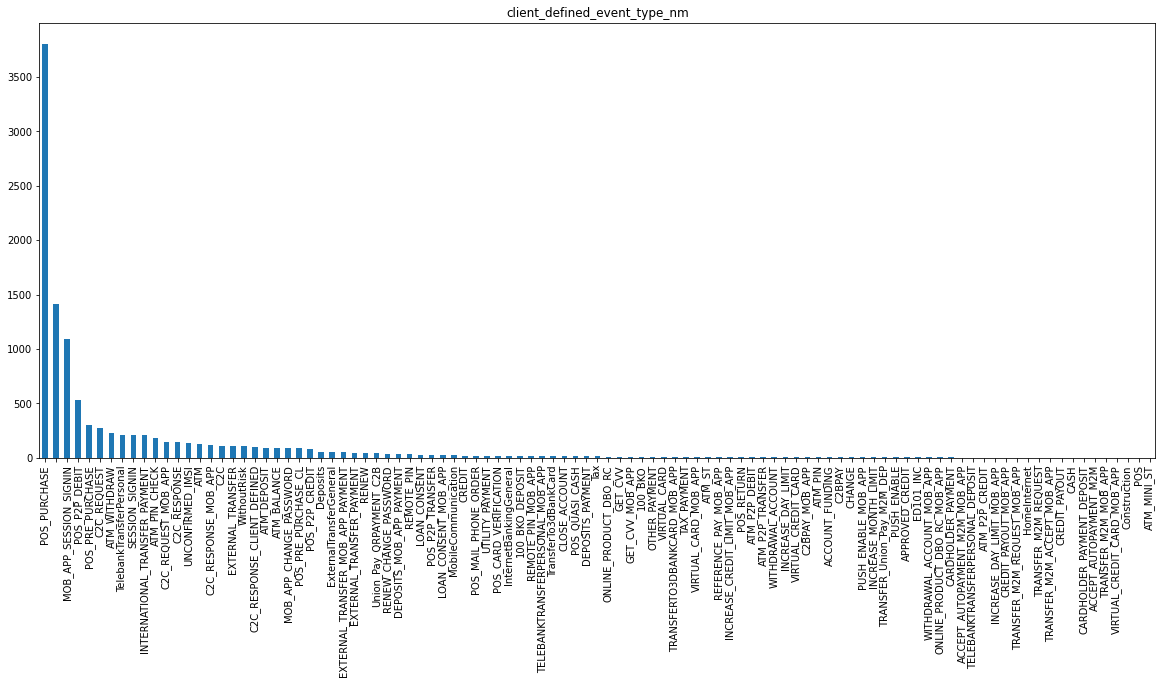

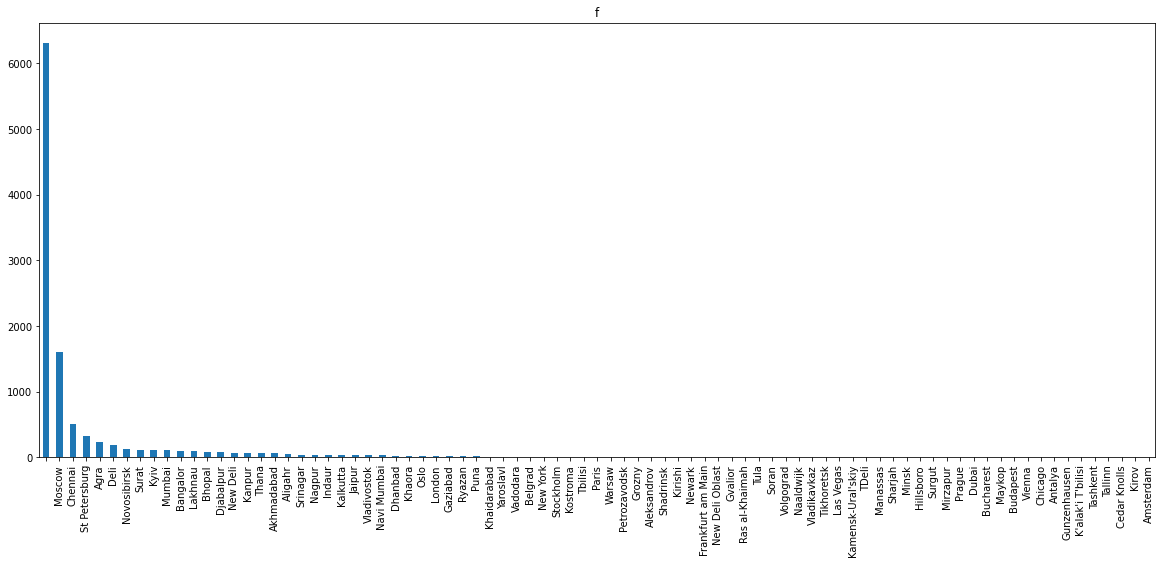

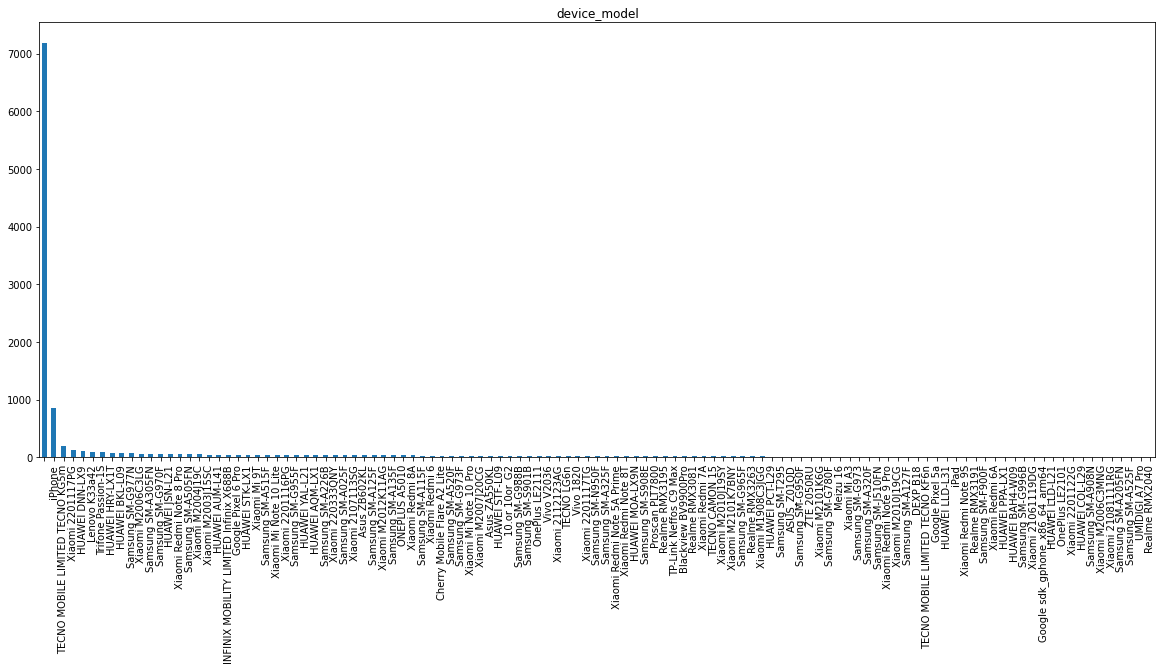

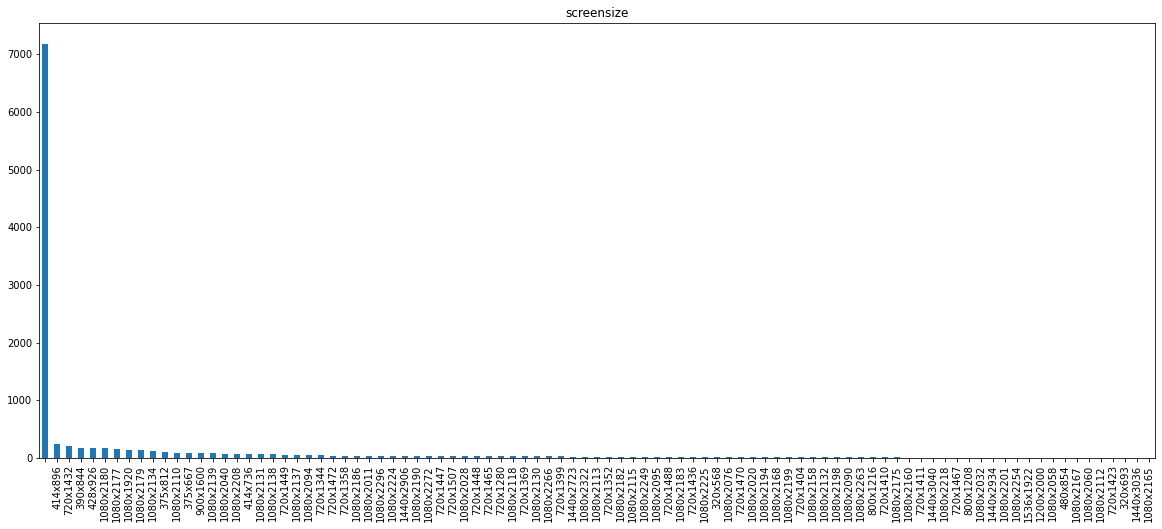

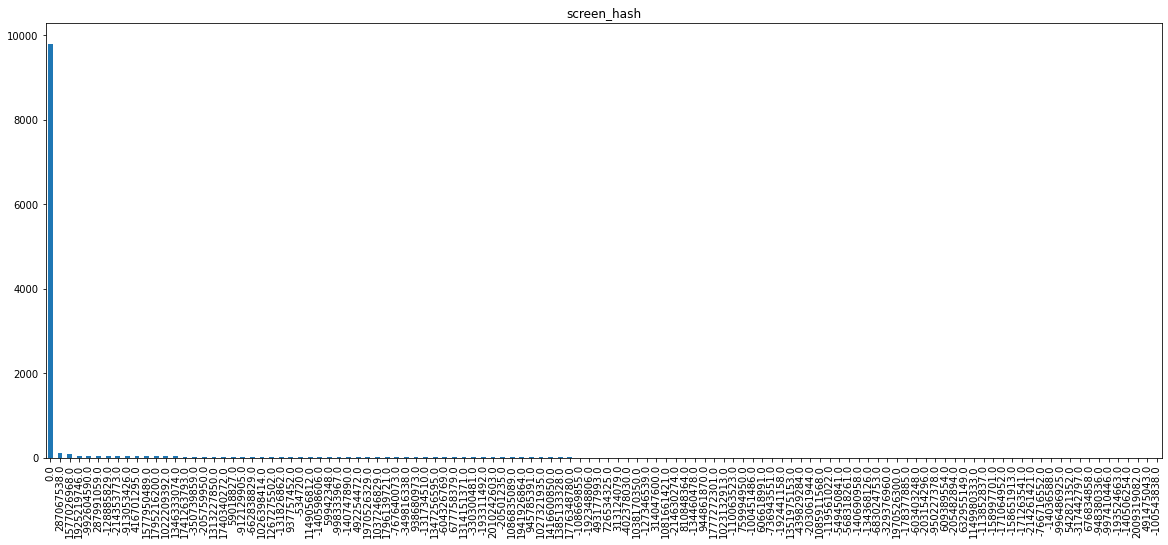

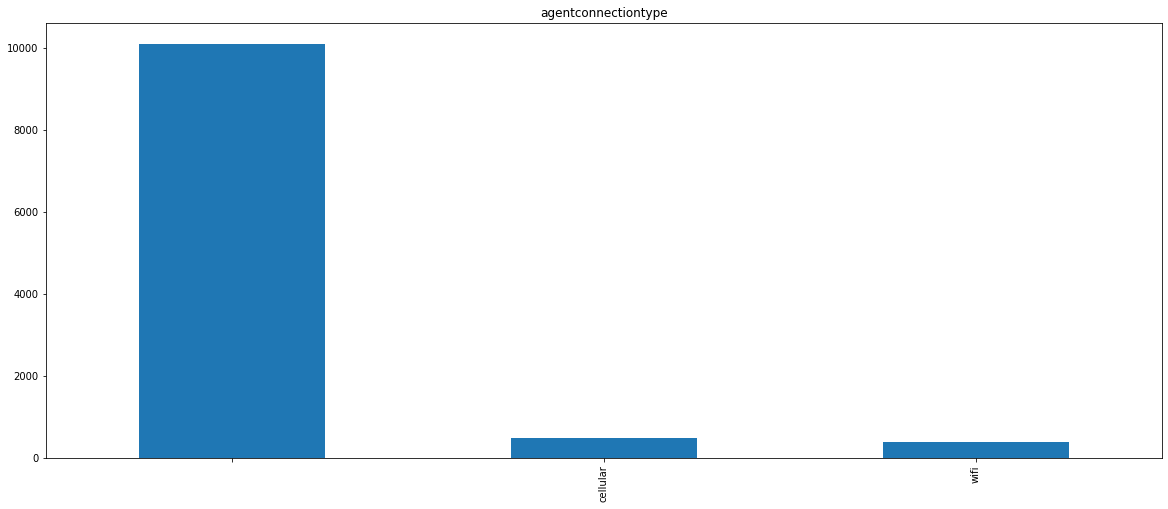

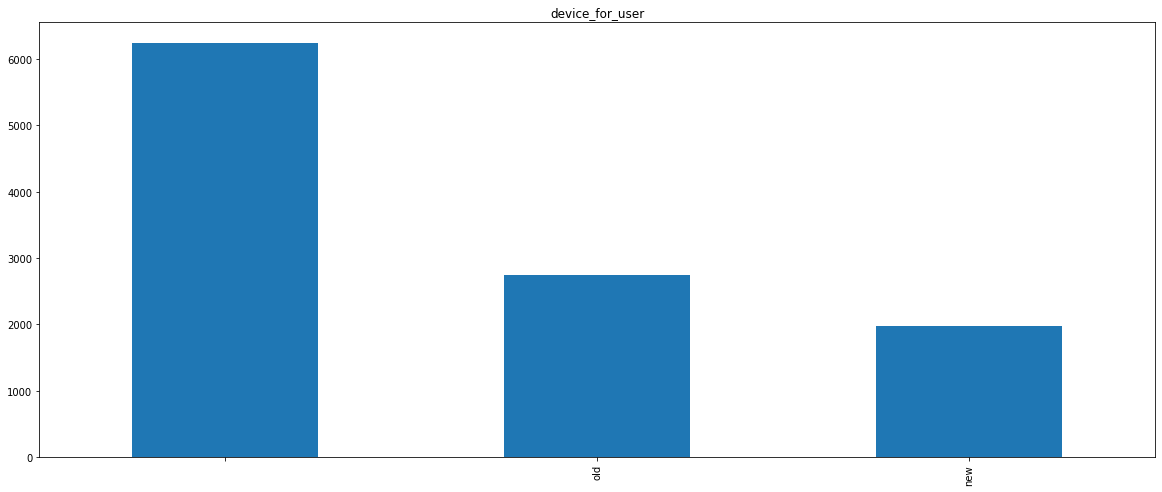

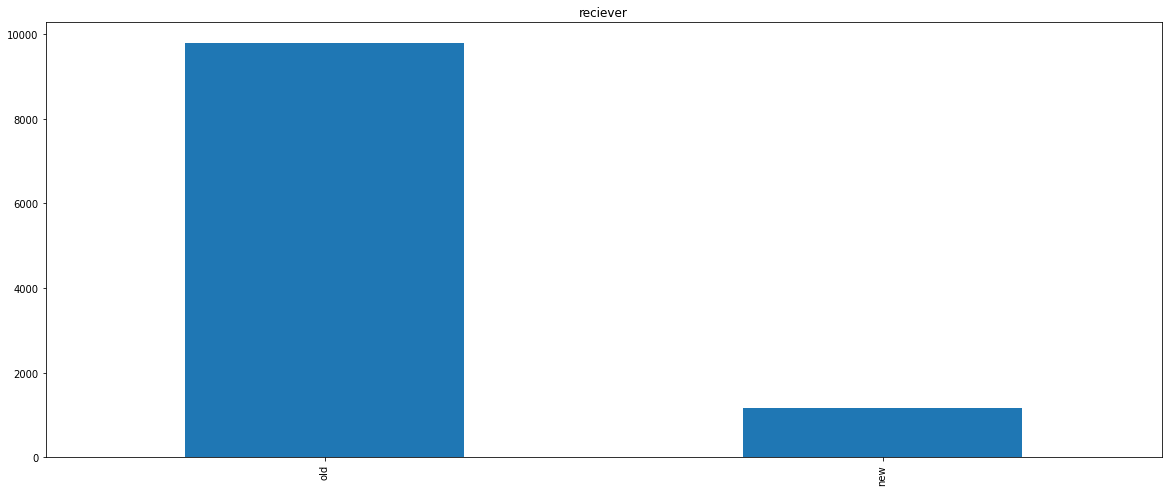

In [133]:
for c in ['event_type_nm', 'client_defined_event_type_nm', 'f', 'device_model', 'screensize', 
          'screen_hash', 'agentconnectiontype', 'device_for_user', 'reciever']:
    df[c].value_counts().plot.bar(figsize=(20,8))
    plt.title(c)
    plt.show()

In [134]:
df['pre_auth_flag'] = df['event_desc'].str.lower().str.contains('authorization')
df['pre_auth_amount'] = df.apply(lambda x: x['operaton_amt_100_rupees'] if x['pre_auth_flag'] else 0, axis=1)

# Session slicing

In [135]:
df.sort_values(['customer_id', 'event_dttm_Deli'], inplace=True)
df['new_session'] = (df['event_type_nm'] == 'SESSION_SIGNIN').astype(int)
df['session_num'] = df.groupby('customer_id')['new_session'].cumsum()
df.drop(['new_session'], axis=1, inplace=True)

In [136]:
df

,customer_id,event_dttm_Deli,event_type_nm,client_defined_event_type_nm,event_desc,operaton_amt_100_rupees,active_phone_call,remote_desktop_protokol,emulator,f,...,agentconnectiontype,screen_hash,device_for_user,reciever,password_change,fast_change_of_ip,ip_not_equal_to_previous,pre_auth_flag,pre_auth_amount,session_num
0,customer_id_0,2022-10-01 10:51:36,CHANGE_PASSWORD,RENEW,Login password recovery,0.00,0.0,0.0,1.0,St Petersburg,...,,287067538.0,new,old,,,IP differes,False,0.0,0
1,customer_id_0,2022-10-01 11:15:21,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.00,0.0,0.0,1.0,St Petersburg,...,,287067538.0,new,old,happened on the same day,,IP differes,False,0.0,1
2,customer_id_0,2022-10-01 11:31:55,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.00,0.0,0.0,1.0,St Petersburg,...,,-205759950.0,new,old,happened on the same day,,IP differes,False,0.0,2
3,customer_id_0,2022-10-01 11:45:42,SESSION_SIGNIN,SESSION_SIGNIN,Login,0.00,0.0,0.0,1.0,St Petersburg,...,,287067538.0,new,old,happened on the same day,,IP differes,False,0.0,3
4,customer_id_0,2022-10-03 10:28:24,DEPOSIT,100_BKO,Payment order,116820.00,1.0,0.0,1.0,,...,wifi,0.0,,old,,,,False,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,customer_id_99,2022-11-19 18:32:44,PAYMENT,POS_PURCHASE,Purchase,1450.22,0.0,0.0,1.0,,...,,0.0,,old,,,,False,0.0,21
4000,customer_id_99,2022-11-20 00:08:33,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,Login,0.00,0.0,0.0,1.0,Moscow,...,wifi,0.0,old,old,,,IP differes,False,0.0,22
4001,customer_id_99,2022-11-20 15:36:10,SESSION_SIGNIN,MOB_APP_SESSION_SIGNIN,Login,0.00,0.0,0.0,1.0,Moscow,...,cellular,0.0,old,old,,,IP differes,False,0.0,23
4002,customer_id_99,2022-11-20 15:47:50,PAYMENT,POS_PURCHASE,Purchase,1294.46,0.0,0.0,1.0,,...,,0.0,,old,,,,False,0.0,23


In [137]:
session_df = df\
    .groupby(['customer_id','session_num']).agg(
                timestamp_min = ('event_dttm_Deli', 'min'),
                timestamp_max = ('event_dttm_Deli', 'max'),
                event_type_count = ('event_type_nm', 'count'),
                event_desc = ('event_desc', lambda x: ','.join(x)),
                amount_sum = ('operaton_amt_100_rupees', 'sum'),
                curr_device = ('device_model', lambda x: x.value_counts().index[0]),
                curr_location = ('f', lambda x: x.value_counts().index[0]),
                pre_auth_count = ('pre_auth_flag', 'sum'),
                pre_auth_amt = ('pre_auth_amount', 'sum'))

In [138]:
session_df.reset_index(inplace=True)

In [139]:
session_df['session_duration'] = (session_df['timestamp_max'] - session_df['timestamp_min']).astype('timedelta64[s]')
session_df['event_desc'] = session_df['event_desc'].str.lower()
session_df['event_desc_flag'] = session_df['event_desc'].str.contains('password') & (session_df['event_desc'].str.contains('payment') | session_df['event_desc'].str.contains('purchase'))

In [140]:
session_df

,customer_id,session_num,timestamp_min,timestamp_max,event_type_count,event_desc,amount_sum,curr_device,curr_location,pre_auth_count,pre_auth_amt,session_duration,event_desc_flag
0,customer_id_0,0,2022-10-01 10:51:36,2022-10-01 10:51:36,1,login password recovery,0.00,,St Petersburg,0,0.0,0.0,False
1,customer_id_0,1,2022-10-01 11:15:21,2022-10-01 11:15:21,1,login,0.00,,St Petersburg,0,0.0,0.0,False
2,customer_id_0,2,2022-10-01 11:31:55,2022-10-01 11:31:55,1,login,0.00,,St Petersburg,0,0.0,0.0,False
3,customer_id_0,3,2022-10-01 11:45:42,2022-10-03 10:28:24,2,"login,payment order",116820.00,,,0,0.0,168162.0,False
4,customer_id_0,4,2022-10-03 10:29:37,2022-10-03 10:29:37,1,login,0.00,,St Petersburg,0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,customer_id_99,20,2022-11-18 18:35:22,2022-11-18 20:14:57,4,"login,purchase,purchase,purchase",17223.28,,,0,0.0,5975.0,False
2742,customer_id_99,21,2022-11-18 20:20:19,2022-11-19 18:32:44,6,"login,payment between telebank clients (person...",78962.06,,Moscow,0,0.0,79945.0,False
2743,customer_id_99,22,2022-11-20 00:08:33,2022-11-20 00:08:33,1,login,0.00,iPhone,Moscow,0,0.0,0.0,False
2744,customer_id_99,23,2022-11-20 15:36:10,2022-11-20 15:47:50,2,"login,purchase",1294.46,,Moscow,0,0.0,700.0,False


# Customer profiling

In [141]:
from statistics import mean,mode,stdev

customer_df = df.fillna('').groupby(['customer_id']).agg(
    amount_stdev = ('operaton_amt_100_rupees',stdev),amount_mean = ('operaton_amt_100_rupees','mean'),device = ('device_model',max),operating_sys = ('os','max'),location = ('f','max') 
)

# Merge Customer with Session

In [142]:
df_merged = pd.merge(session_df, customer_df, left_on='customer_id', right_on='customer_id', how='left')

df_merged['amount_flag'] = df_merged['amount_sum'] > df_merged['amount_stdev'] 

In [143]:
df_merged['device_flag'] = df_merged['curr_device'] != df_merged['device']
df_merged['location_flag'] = df_merged['curr_location'] != df_merged['location'] 

In [144]:
pd.set_option('display.max_columns', None)
df_merged

,customer_id,session_num,timestamp_min,timestamp_max,event_type_count,event_desc,amount_sum,curr_device,curr_location,pre_auth_count,pre_auth_amt,session_duration,event_desc_flag,amount_stdev,amount_mean,device,operating_sys,location,amount_flag,device_flag,location_flag
0,customer_id_0,0,2022-10-01 10:51:36,2022-10-01 10:51:36,1,login password recovery,0.00,,St Petersburg,0,0.0,0.0,False,172225.843084,110242.297297,iPhone,iOS,St Petersburg,False,True,False
1,customer_id_0,1,2022-10-01 11:15:21,2022-10-01 11:15:21,1,login,0.00,,St Petersburg,0,0.0,0.0,False,172225.843084,110242.297297,iPhone,iOS,St Petersburg,False,True,False
2,customer_id_0,2,2022-10-01 11:31:55,2022-10-01 11:31:55,1,login,0.00,,St Petersburg,0,0.0,0.0,False,172225.843084,110242.297297,iPhone,iOS,St Petersburg,False,True,False
3,customer_id_0,3,2022-10-01 11:45:42,2022-10-03 10:28:24,2,"login,payment order",116820.00,,,0,0.0,168162.0,False,172225.843084,110242.297297,iPhone,iOS,St Petersburg,False,True,True
4,customer_id_0,4,2022-10-03 10:29:37,2022-10-03 10:29:37,1,login,0.00,,St Petersburg,0,0.0,0.0,False,172225.843084,110242.297297,iPhone,iOS,St Petersburg,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,customer_id_99,20,2022-11-18 18:35:22,2022-11-18 20:14:57,4,"login,purchase,purchase,purchase",17223.28,,,0,0.0,5975.0,False,37321.371793,15444.667761,iPhone,iOS,Moscow,False,True,True
2742,customer_id_99,21,2022-11-18 20:20:19,2022-11-19 18:32:44,6,"login,payment between telebank clients (person...",78962.06,,Moscow,0,0.0,79945.0,False,37321.371793,15444.667761,iPhone,iOS,Moscow,True,True,False
2743,customer_id_99,22,2022-11-20 00:08:33,2022-11-20 00:08:33,1,login,0.00,iPhone,Moscow,0,0.0,0.0,False,37321.371793,15444.667761,iPhone,iOS,Moscow,False,False,False
2744,customer_id_99,23,2022-11-20 15:36:10,2022-11-20 15:47:50,2,"login,purchase",1294.46,,Moscow,0,0.0,700.0,False,37321.371793,15444.667761,iPhone,iOS,Moscow,False,True,False


In [146]:
pd.reset_option('display.max_columns')

In [145]:
df_final = df_merged[['customer_id','session_num','event_type_count','pre_auth_count','pre_auth_amt','session_duration','event_desc_flag','amount_stdev','amount_mean','amount_flag','device_flag','location_flag']].copy()
df_final.set_index(['customer_id','session_num'], inplace=True)

In [147]:
df_final

event_type_count  pre_auth_count  pre_auth_amt  \
customer_id    session_num                                                   
customer_id_0  0                           1               0           0.0   
               1                           1               0           0.0   
               2                           1               0           0.0   
               3                           2               0           0.0   
               4                           1               0           0.0   
...                                      ...             ...           ...   
customer_id_99 20                          4               0           0.0   
               21                          6               0           0.0   
               22                          1               0           0.0   
               23                          2               0           0.0   
               24                          1               0           0.0   

                            session_duration  event_desc_flag   amount_stdev  \
customer_id    session_num                                                     
customer_id_0  0                         0.0            False  172225.843084   
               1                         0.0            False  172225.843084   
               2                         0.0            False  172225.843084   
               3                    168162.0            False  172225.843084   
               4                         0.0            False  172225.843084   
...                                      ...              ...            ...   
customer_id_99 20                     5975.0            False   37321.371793   
               21                    79945.0            False   37321.371793   
               22                        0.0            False   37321.371793   
               23                      700.0            False   37321.371793   
               24                        0.0            False   37321.371793   

                              amount_mean  amount_flag  device_flag  \
customer_id    session_num                                            
customer_id_0  0            110242.297297        False         True   
               1            110242.297297        False         True   
               2            110242.297297        False         True   
               3            110242.297297        False         True   
               4            110242.297297        False         True   
...                                   ...          ...          ...   
customer_id_99 20            15444.667761        False         True   
               21            15444.667761         True         True   
               22            15444.667761        False        False   
               23            15444.667761        False         True   
               24            15444.667761        False        False   

                            location_flag  
customer_id    session_num                 
customer_id_0  0                    False  
               1                    False  
               2                    False  
               3                     True  
               4                    False  
...                                   ...  
customer_id_99 20                    True  
               21                   False  
               22                   False  
               23                   False  
               24                   False  

[2746 rows x 10 columns]

In [148]:
from kmodes.kmodes import KModes
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 11602.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 11602.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 11602.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 11602.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 11602.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 306, cost: 10006.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 383, cost: 10102.0
Run 2, iteration: 2/100, moves: 1, cost: 10102.0
Init: initializing cen

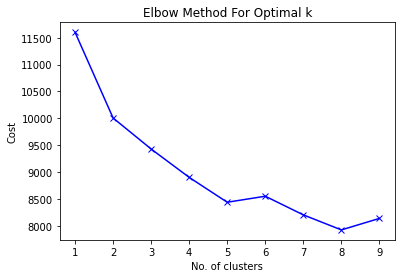

In [149]:
%matplotlib inline
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df_final)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [162]:
%%time

score_opt = {}

for i in range(2, 10):
    kmode = KModes(n_clusters=3, init = "random", n_init = i, verbose=1)
    clusters = kmode.fit_predict(df_final)
    score_opt[i] = silhouette_score(df_final, clusters)
max(score_opt.values())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 41, cost: 9369.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 252, cost: 9417.0
Run 2, iteration: 2/100, moves: 204, cost: 9417.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 332, cost: 9351.0
Run 1, iteration: 2/100, moves: 118, cost: 9351.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 713, cost: 9423.0
Run 2, iteration: 2/100, moves: 148, cost: 9423.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 401, cost: 9563.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 547, cost: 9426.0
Run 1, iteration: 2/100, mo

-0.01920058998228939

In [153]:
print(f'Silhouette Score: {silhouette_score(df_final, clusters)}')

Silhouette Score: -0.07166312304636313
